### LSTM Network 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm  import tqdm_notebook #used for loading bar (e.g. to visualise how long an operation is taking)

#read in data
import requests
import tarfile
import os
import zipfile
import regex as re #to clean the text
import string

In [2]:
def maybe_download(data_url, path):
    if os.path.exists(os.getcwd()+"/"+path):
        print("Data already present.")
    else:
        print("Downloading data...")
        r = requests.get(data_url, stream=True)
        file_name = data_url.split("/")[-1]
        with open(file_name,'wb') as f:
            total_length = int(r.headers.get('content-length'))
            for chunk in tqdm_notebook(r.iter_content(chunk_size=8192), total=(total_length//8192) + 1): 
                if chunk:
                    f.write(chunk)
                    f.flush()
        print("Extracting data")
        if "tar" in file_name:
            unzipper = tarfile.open(file_name)
        elif "zip" in file_name:
            unzipper = zipfile.ZipFile(file_name,"r")
        unzipper.extractall()
        unzipper.close()
        os.remove(path) 
        print("Success: Data downloaded and extracted.")

In [3]:
maybe_download(data_url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", path="aclImdb")

Data already present.


In [4]:
maybe_download(data_url="http://nlp.stanford.edu/data/wordvecs/glove.6B.zip", path="glove.6B.50d.txt")

Data already present.


In [5]:
def get_GloVe_vecs(embedding_size):
    file_name = "glove.6B." + str(embedding_size) + "d.txt"
    with open(file_name,'r') as f:
        word_to_glove = {}
        for line in f:
            line =line.strip().split()
            word = line[0]
            vec = np.array(line[1:], dtype=np.float64)
            word_to_glove[word]= vec
    return word_to_glove



In [17]:
def clean_line(s):
    s = s.lower()
    return re.sub('[%s]' % re.escape(string.punctuation), '', s)

def preprocess_input(path,embedding_size,max_length):
    word_to_glove = get_GloVe_vecs(embedding_size)
    X = np.zeros((25000,embedding_size,max_length))
    Y = np.zeros((1,25000))
    reviews = [] #track file associated with respective input features 
    Y[:,:12500] =1
    for k,label in enumerate(["pos", "neg"]):
        for i, file in enumerate(tqdm_notebook(os.listdir(os.fsencode(path+'/'+label)), total=12500)):
            filename = os.fsdecode(file)
            with open(path+'/'+label+'/'+filename, 'r') as f:
                num_words=0
                reviews.append(path+'/'+label+'/'+filename)
                for line in f:
                    line = clean_line(line)
                    for word in line.strip().split():
                        if num_words>=max_length:
                            break
                        if word in word_to_glove.keys():
                            X[k*12500+i,:,num_words] = word_to_glove.get(word) #first 12500 are pos, second 12500 are neg
                            num_words+=1
                    if num_words>=max_length:
                        break
    #shuffle indices
    idx = np.random.permutation(25000)
    X = X[idx]
    Y = Y[:,idx]
    reviews = np.array(reviews)[idx]
    return X, Y,reviews

In [18]:
X_train, Y_train,train_reviews = preprocess_input('aclImdb/train/', embedding_size=100,max_length=200)
X_test, Y_test, test_reviews = preprocess_input('aclImdb/test/', embedding_size=100,max_length=200)


In [8]:
i = np.random.randint(0,25000)
print((Y_train[:,i]))
with open(train_reviews[i],'r') as f:
    for line in f:
        print(line)

[1.]
a must see i saw whipped at a press screening and it was hilarious were talking nonstop laughs it makes something about mary seem like a meandering drama amanda peet screams star quality with her winning combination of beauty brains and serious acting ability peter cohen the director has made a cutting edge film that shows the raw inside of mens egos in the urban dating world for all of its comedy whipped succeeds with its intelligence which is so rare for a first time director especially with a romantic comedy he is a major talent judah domke brian van holt jonathan abrahams and barber round out the cast with depth and very strong performances as the would be slick men got to see these guys go to work and get caught in peets web check out the trailer on its worth the 3 minute download 



A MUST SEE! I saw WHIPPED at a press screening and it was hilarious. We're talking nonstop laughs. It makes SOMETHING ABOUT MARY seem like a meandering drama. Amanda Peet screams star quality wi

In [9]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))


def initialise_parameters(n_a,n_x):
    Wg, bg = np.random.randn(3*n_a,n_a+n_x), np.zeros((3*n_a, 1))
    Wc, bc = np.random.randn(n_a,n_a+n_x), np.zeros((n_a, 1))
    Wy, by = np.random.randn(1,n_a), np.zeros((1, 1))
    a0 = c0 = np.zeros((n_a,1))
    parameters = {"Wg": Wg,"Wc": Wc,"Wy": Wy,"bg": bg, "bc": bc,"by": by, "a0": a0, "c0":c0}
    return parameters
    
def forward_step(a_prev, x, c_prev, parameters):
    n_a = a_prev.shape[0]
    input_concat = np.concatenate((a_prev, x),axis=0)
    IFO_gates = sigmoid(parameters["Wg"].dot(input_concat)+parameters["bg"])
    c_candidate = np.tanh(parameters["Wc"].dot(input_concat)+parameters["bc"])
    c_next = IFO_gates[:n_a]*c_candidate + IFO_gates[n_a:2*n_a]*c_prev
    a_next = IFO_gates[2*n_a:]*np.tanh(c_next)
    cache = (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates)
    return a_next, c_next, cache


def backward_step(dA_next, dC_next,cache,parameters):
    (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates) = cache
    n_a, m = a_next.shape
    
    dC_next += dA_next* (IFO_gates[2*n_a:]*(1-np.tanh(c_next)**2))
    
    dC_prev = dC_next * IFO_gates[n_a:2*n_a]
    dC_candidate =  dC_next * IFO_gates[:n_a]
    
    dIFO_gates = np.zeros_like(IFO_gates)
    dIFO_gates[:n_a] = dC_next * c_candidate 
    dIFO_gates[n_a:2*n_a]= dC_next * c_prev
    dIFO_gates[2*n_a:] = dA_next * np.tanh(c_next)

    dZ_gate =  dIFO_gates* (IFO_gates*(1-IFO_gates))   
    dA_prev =  (parameters["Wg"].T).dot(dZ_gate)[:n_a]
    dWg = (1/m)*dZ_gate.dot(input_concat.T)
    dbg = (1/m)*np.sum(dZ_gate,axis=1, keepdims=True)
    
    dZ_c = dC_candidate * (1-c_candidate**2)
    dA_prev +=  (parameters["Wc"].T).dot(dZ_c)[:n_a]
    dWc = (1/m)*dZ_c.dot(input_concat.T)
    dbc = (1/m)*np.sum(dZ_c,axis=1, keepdims=True)  
    
    return dA_prev, dC_prev, dWg, dbg, dWc, dbc



In [10]:
def forward_prop(X, parameters):
    m, _, Tx = X.shape
    a = np.repeat(parameters["a0"],m, axis=1)
    c = np.repeat(parameters["c0"],m, axis=1)
    caches= []
    for t in range(Tx):
        xt = np.squeeze(X[:,:,t]).T #so 2D matrix n_x, m
        a, c, cache = forward_step(a,xt , c, parameters)
        caches.append(cache)
    y_pred = sigmoid(parameters["Wy"].dot(a)+parameters["by"])
    return y_pred, caches


def backprop(X,y, y_pred, parameters, caches,lambd):
    m, _, Tx = X.shape
    grads = {}
    
    
    dZ_pred = (y_pred-y) 
    dA =  (parameters["Wy"].T).dot(dZ_pred)
    grads["dWy"] = (1/m)*dZ_pred.dot(caches[Tx-1][0].T) #this is A<T_X>
    grads["dby"] = (1/m)*np.sum(dZ_pred,axis=1, keepdims=True)
    
    dC = np.zeros_like(dA)
    
    grads["dWg"] = np.zeros_like(parameters["Wg"])
    grads["dbg"] = np.zeros_like(parameters["bg"])
    grads["dWc"] = np.zeros_like(parameters["Wc"])
    grads["dbc"] = np.zeros_like(parameters["bc"])
    
    
    for t in reversed(range(Tx)):
        (dA, dC, dWg, dbg, dWc, dbc) = backward_step(dA, dC, caches[t],parameters)
        grads["dWg"] += dWg
        grads["dbg"] += dbg
        grads["dWc"] += dWc
        grads["dbc"] += dbc
    
    grads["da0"] = np.sum(dA,axis=1,keepdims=True)
    grads["dc0"] = np.sum(dC,axis=1,keepdims=True)
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]+= (lambd/m)*parameters[key[1:]] 
    
    return grads


In [11]:
def loss_function(y_pred,y, parameters, lambd):
    m = y.shape[1]
    cost = (-1/m)*np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W" in key:
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost


In [12]:
def accuracy(y_pred,y):
    preds = np.rint(y_pred) #round to int
    return np.mean(np.equal(preds,y).astype(int))

In [13]:
def backprop_checker(parameters,grads, x, y,lambd):
    epsilon = 1e-7
    rel_threshold = 1e-2
    num_sample = 10
    flag = True #if backprop is correct
    print("Checking gradients...")
    for param in parameters.keys(): 
        print("Checking: " + param)
        dims = parameters[param].shape
        
        
        num_grad = 0
        backprop_grad = 0
        
        for _ in range(num_sample): #sample 10 neurons
            idx = np.zeros(len(dims))
            for i in range(len(dims)):
                idx[i] = np.random.randint(0,dims[i])
            idx = tuple(idx.astype(int))

            parameters[param][idx]= parameters[param][idx] + epsilon
            y_pred_plus = forward_prop(x,parameters)[0]
            J_plus = loss_function(y_pred_plus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx] - 2*epsilon

            y_pred_minus = forward_prop(x,parameters)[0]

            J_minus = loss_function(y_pred_minus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx]+ epsilon

            num_grad += (J_plus-J_minus)/(2*epsilon)
            backprop_grad += grads["d"+param][idx]
            
            
        num_grad/=num_sample
        backprop_grad/=num_sample
        rel_error = abs((num_grad-backprop_grad)/num_grad)
        if rel_error>rel_threshold:
            #print("J_plus: "+ str(J_plus))
            #print("J_minus: "+ str(J_minus))
            print("Numerical grad:" + str(num_grad))
            print("Backprop grad:" + str(backprop_grad))
 
            print("Relative error: " + str(rel_error))
            if not (num_grad<1e-6 and backprop_grad<1e-6):
                flag = False
                print("Backprop calculation incorrect")
    print("Gradient check complete")
    assert(flag) #if not the backprop is massively out so kill training

In [14]:
def forward_checker(caches):
    for i, cache in enumerate(caches):
        n_a = cache[0].shape[0]
        keys = ("a_next", "c_next", "input_concat", "c_prev", "c_candidate","IFO_gates")
        for j, val in enumerate(cache):
            if "input_concat" in keys[j] and (i==0 or i==100 or i==199):
                print("\n\nCache" + str(i))
                print(keys[j])
                print(val[:n_a])
               

In [15]:
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs, batch_size,lambd,learning_rate,num_hidden_units=512, parameters = None ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    m, n_x, T_x = X_train.shape

    
    if parameters==None:
        parameters = initialise_parameters(num_hidden_units, n_x)
        
    for epoch in tqdm_notebook(range(num_epochs),total=num_epochs):
        #cycle through the entire training set in batches
        for i in tqdm_notebook(range(0,m//batch_size), total =m//batch_size, desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, caches = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, caches,lambd)
            
            #check backprop calculations - comment out once satisfied      
            
            
            if(i%25==0):
                forward_checker(caches)
               # backprop_checker(parameters,minibatch_grads, X_train_minibatch, Y_train_minibatch,lambd)

            #update the parameters using gradient descent
            for param in parameters.keys():
                parameters[param] = parameters[param] - learning_rate*minibatch_grads["d"+param]
            
            #visualise error
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()
            
            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%100 == 0):
                print("Training set error: "+ str(minibatch_cost))
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

<IPython.core.display.Javascript object>


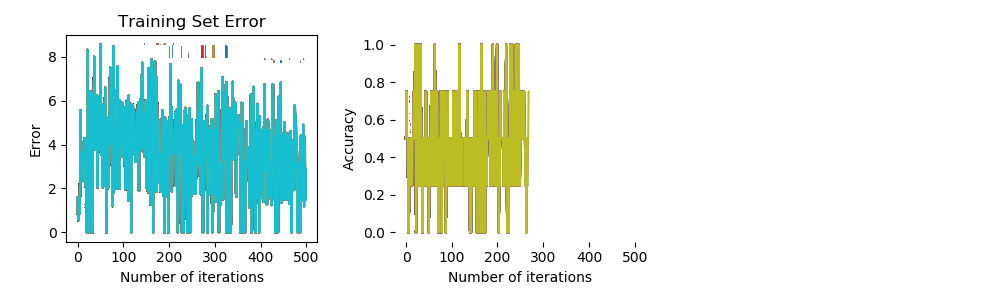



Cache0
input_concat
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Cache100
input_concat
[[-9.72222118e-01 -8.57358880e-01 -9.28514277e-01 -4.03942882e-01]
 [ 8.83497030e-01  7.65233991e-01  9.82934855e-01  9.99805957e-01]
 [ 7.91578885e-04  4.31374723e-03  2.44576321e-02  1.85194239e-03]
 [-4.24102597e-05 -6.37908132e-01 -2.44106928e-03  1.00346170e-07]
 [-6.92486552e-01 -2.62220593e-01 -6.57690819e-01 -9.88519577e-01]
 [ 1.76989086e-01  5.05939785e-01  8.85483290e-04  6.08333638e-01]
 [-1.59673905e-02  2.15090958e-05  5.97243543e-02 -2.40316537e-02]
 [-2



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157



Cache0
input_concat
[[ 2.11215905e+04  2.11215905e+04  2.11215905e+04  2.11215905e+04]
 [ 1.16367055e+05  1.16367055e+05  1.16367055e+05  1.16367055e+05]
 [-4.25924494e+04 -4.25924494e+04 -4.25924494e+04 -4.25924494e+04]
 [ 2.24972036e+04  2.24972036e+04  2.24972036e+04  2.24972036e+04]
 [-2.55101138e+05 -2.55101138e+05 -2.55101138e+05 -2.55101138e+05]
 [ 3.28264476e+05  3.28264476e+05  3.28264476e+05  3.28264476e+05]
 [ 9.84822716e+02  9.84822716e+02  9.84822716e+02  9.84822716e+02]
 [-3.16844124e+04 -3.16844124e+04 -3.16844124e+04 -3.16844124e+04]
 [-9.84182733e+04 -9.84182733e+04 -9.84182733e+04 -9.84182733e+04]
 [ 2.24199210e+04  2.24199210e+04  2.24199210e+04  2.24199210e+04]
 [-1.39178940e+05 -1.39178940e+05 -1.39178940e+05 -1.39178940e+05]
 [-1.25528339e+05 -1.25528339e+05 -1.25528339e+05 -1.25528339e+05]
 [ 4.30412298e+03  4.30412298e+03  4.30412298e+03  4.30412298e+03]
 [ 1.71639921e+04  1.71639921e+04  1.71639921e+04  1.71639921e+04]
 [-3.15700671e+04 -3.15700671e+04 -3.157

KeyboardInterrupt: 

In [16]:
parameters = train_model(X_train,Y_train,X_test[:1000],Y_test[:,:1000],num_epochs=10, batch_size=4,lambd=0,
                         learning_rate=1e-3,num_hidden_units=32)